# GOES and IBTrACS Data with Projections

Now that we've explored the GOES satellite data and the IBTrACS data in Python, let's put them both together. In order to do so, we'll have to obtain the projection data of the GOES imagery, project the IBTrACS latitudes/longitudes using the GOES projection data, and then overlay the track on the GOES imagery.

Rather than using the entirety of the IBTrACS data, we focus specifically on the track of [Hurricane Harvey in 2017](https://en.wikipedia.org/wiki/Hurricane_Harvey). This was a devastating storm that first made landfall in Texas. I chose this storm because I'm pretty familiar with it and know roughly what to expect for the imagery and the track.

## Import Modules

Let's first import the modules we need to run the code. I've written some functions for getting the IBTrACS and GOES data, so let's import those functions now too.

In [1]:
# Import modules
import matplotlib.pyplot as plt
import os
import datetime
from pyproj import Proj
from mpl_toolkits.basemap import Basemap
import numpy as np

# Import functions I've written
os.chdir("..")
import goes
import ibtracs

## Retrieve IBTrACS Data

Now let's load up the IBTrACS data, as we did in a previous notebook, and then drill down on the track for Hurricane Harvey in 2017.

In [2]:
# Set the file path for the IBTrACS data
filePath = ibtracs.download_data(basin="NA",overwrite=False)

# Read the data from the CSV
df = ibtracs.read_data(filePath)

# Keep only the Hurricane Harvey (2017) track
df = df[df['SEASON'] == 2017]
df = df[df['NAME'] == 'HARVEY']

# Show a preview
df.head()

,SID,SEASON,NUMBER,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,STORM_SPEED,STORM_DIR
675957,2017228N14314,2017,61,HARVEY,2017-08-16 06:00:00,DS,13.7000,-45.8000,25,1013,main,1209,1157,O_____________,16,271
675958,2017228N14314,2017,61,HARVEY,2017-08-16 09:00:00,DS,13.7130,-46.5999,,,main,1157,1109,P_____________,16,270
675959,2017228N14314,2017,61,HARVEY,2017-08-16 12:00:00,DS,13.7000,-47.4000,25,1010,main,1109,1067,O_____________,16,268
675960,2017228N14314,2017,61,HARVEY,2017-08-16 15:00:00,DS,13.6497,-48.2001,,,main,1057,1018,P_____________,16,266
675961,2017228N14314,2017,61,HARVEY,2017-08-16 18:00:00,DS,13.6000,-49.0000,25,1009,main,1018,986,O_____________,16,268


## Retrieve GOES16 Image

Now let's grab a GOES16 image corresponding to Hurricane Harvey. It made landfall in Texas around August 25, 2017, so we'll set the date for the image to be that day.

In [3]:
# Set image specific parameters
bucketName = 'noaa-goes16'
date = datetime.datetime(2017,8,25,18)
product = 'ABI-L1b-RadF'
credPath = "secrets.csv"
band = 3

# Get the GOES data
ds = goes.download_data(date,credPath,bucketName,product,band)

Next, let's plot the GOES full disk image

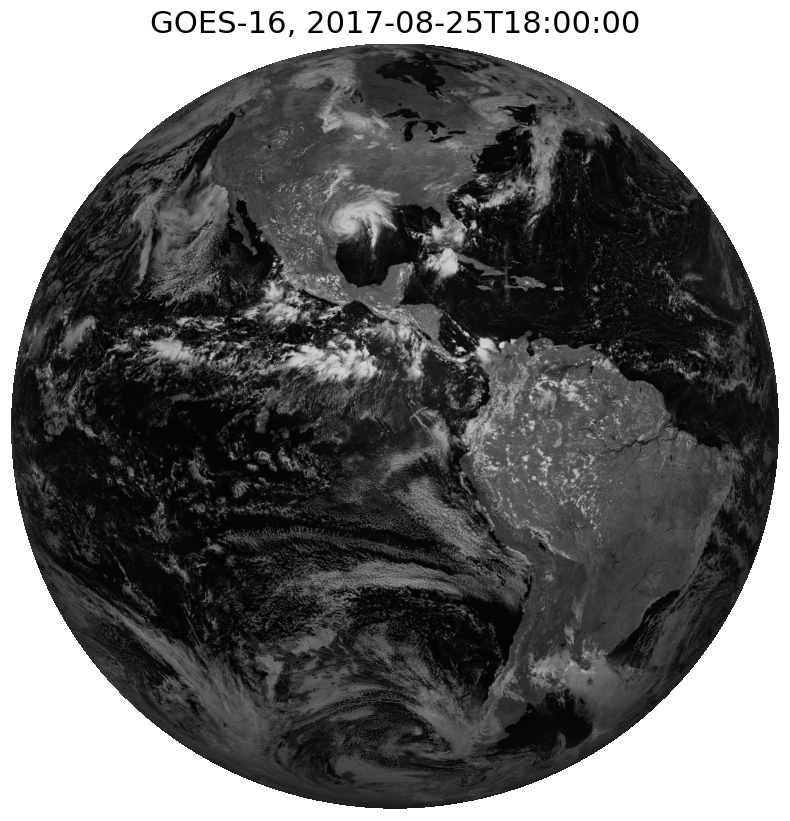

In [4]:
# Create plot
fig, ax = plt.subplots(figsize=(10,10));
ax.imshow(ds.Rad, cmap='gray');
ax.set_title('GOES-16, '+date.isoformat(),fontsize=22);
ax.axis('off');

## Overlay State and Country Borders with Basemap

Now let's experiment with projections. To make sure we've got the projection right, we start by overlaying the boundaries of states, countries, and coastlines on the GOES imagery. In order to do so, we need to get the projection of the GOES data. This information is stored in the netCDF metadata, primarily as attributes for the variable `goes_imager_projection`. So once we get the projection data, we'll load this into the base map, and then the borders should be easily drawn using the base map utilities.

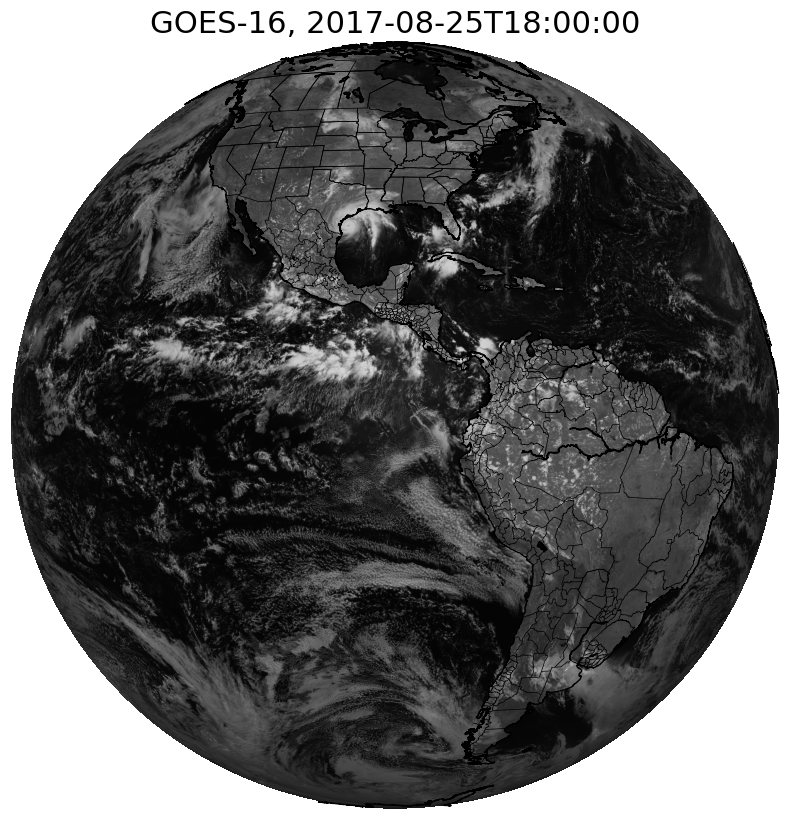

In [5]:
# Get dataset projection data
satHeight = ds.goes_imager_projection.perspective_point_height
satLon = ds.goes_imager_projection.longitude_of_projection_origin
satSweep = ds.goes_imager_projection.sweep_angle_axis
majorMinorAxes = (ds.goes_imager_projection.semi_major_axis,ds.goes_imager_projection.semi_minor_axis)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
x = ds.variables['x'][:] * satHeight
y = ds.variables['y'][:] * satHeight

# Set the geostationary projection
m = Basemap(projection='geos', lon_0=satLon,
            rsphere=majorMinorAxes,
            resolution='i', area_thresh=5000,
            llcrnrx=x.min(),llcrnry=y.min(),
            urcrnrx=x.max(),urcrnry=y.max())

# Create the plot
plt.figure(figsize=(10,10))
m.imshow(np.flipud(ds.Rad), cmap='gray'); 
m.drawcoastlines();
m.drawcountries();
m.drawstates();
plt.axis('off');
plt.title('GOES-16, '+date.isoformat(),fontsize=22);

## Overlay IBTRaCS Data

Now that we can see the projection is working properly, let's add the Hurricane Harvey track as of August 25, 2017 at 18Z. We first need to grab the latitude longitudes from the IBTRaCS data. We can then use `pyproj.Proj` to convert longitudes and latitudes to the $x$ and $y$ space of the projected GOES image.

I don't fully understand this part, but the netCDF $x$ and $y$ arrays go symmetrically from -5434394 to 5434394, but the basemap seems to span from 0 to 10868788. So to properly draw the tracks, we'll need to add 5434394 to the output $x$ and $y$ of `pyproj.Proj` for each longitude and latitude in the track.

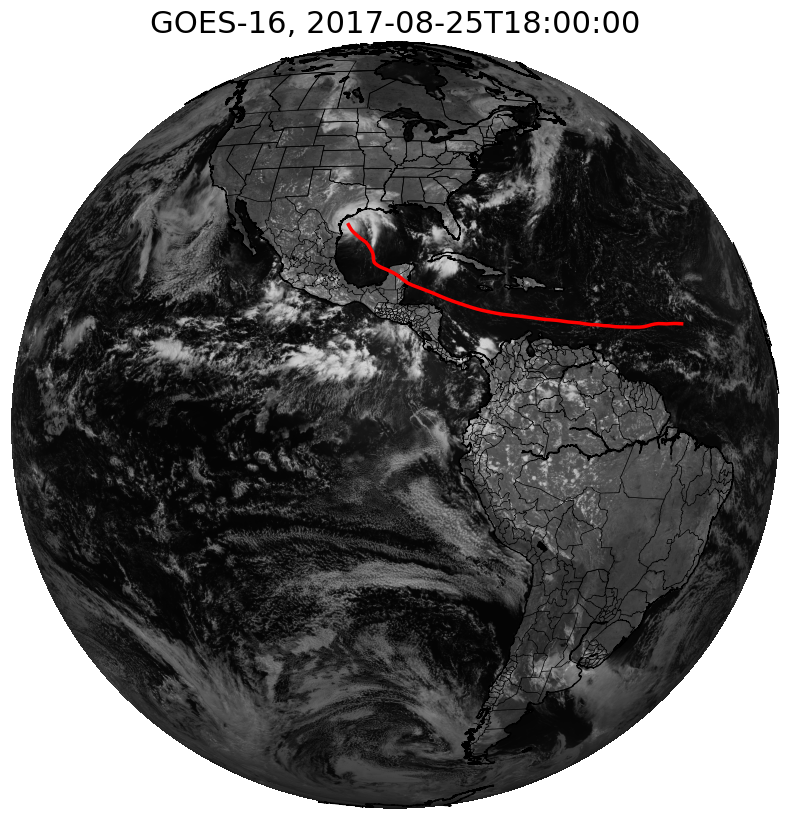

In [6]:
# Get the latitudes/longitudes of the Hurricane Harvey track data
df = df[df['ISO_TIME']<=date]
latList = list(df['LAT'])
lonList = list(df['LON'])

# Create a pyproj geostationary map object
p = Proj(proj='geos', h=satHeight, lon_0=satLon, sweep=satSweep)

# Convert lon/lat to x/y
xList,yList = p(lonList,latList)

# Projected coordinates are negative, but matplotlib starts at 0. 
# Add half of the image width and height to properly draw on map
xList = [point+float(x.max()) for point in xList]
yList = [point+float(y.max()) for point in yList]

# Add track to the basemap plot
plt.figure(figsize=(10,10))
m.imshow(np.flipud(ds.Rad), cmap='gray'); 
m.drawcoastlines();
m.drawcountries();
m.drawstates();
m.plot(xList,yList,linewidth=2.5,color='r')
plt.axis('off');
plt.title('GOES-16, '+date.isoformat(),fontsize=22);